# Baseline models

## Imports

In [1]:
%load_ext autoreload
%autoreload 2



In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm

from fastai.metrics import error_rate, auc_roc_score

import sys
sys.path.append("../scripts/")
from ppmi import *

import fastai.vision as fv

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import fastai
import imageio as io
import pandas as pd
import nibabel
import nilearn.image as nim
import torchvision.models as models
#import keras as K


## Loading and preparing the images

In [8]:
ctrl_imgs_dir = Path("../DTI_png_data/control")
pd_imgs_dir = Path("../DTI_png_data/PD")
ctrl_imgs_paths = list(Path("../DTI_png_data/control").glob("*.nii"))
pd_imgs_paths = list(Path("../DTI_png_data/pd").glob("*.nii"))
metadf = pd.read_csv("dti_all_original_meta_preprocess.csv").rename(columns=PPMI_META_RENAME_DICT)

In [9]:
metadf

,iid,pid,group,sex,age,visit,modality,desc,type,acq_date,fmt
0,226465,PPMI3557,PD,M,59,1,DTI,TRIGGERED DTI,Original,2010-12-22,DCM
1,495186,PPMI41519,GenCohort PD,F,71,1,DTI,TRA/DUAL,Original,2015-03-13,DCM
2,495188,PPMI41519,GenCohort PD,F,71,1,DTI,TRA/DUAL,Original,2015-03-13,DCM
3,880677,PPMI42264,GenCohort PD,F,65,1,DTI,T2,Original,2016-12-02,DCM
4,507861,PPMI41522,GenCohort PD,F,58,1,DTI,T2,Original,2015-06-10,DCM
5,927231,PPMI42269,GenCohort PD,F,67,1,DTI,T2,Original,2017-08-01,DCM
6,507863,PPMI41522,GenCohort PD,F,58,1,DTI,T2,Original,2015-06-10,DCM
7,507864,PPMI41522,GenCohort PD,F,58,1,DTI,T2,Original,2015-06-10,DCM
8,927233,PPMI42269,GenCohort PD,F,67,1,DTI,T2,Original,2017-08-01,DCM
9,507865,PPMI41522,GenCohort PD,F,58,1,DTI,T2,Original,2015-06-10,DCM


In [13]:
fnames = []
labels = []

for p in ctrl_imgs_paths:
    print(p)
    img = load_nifti_img(p)
    fnames.append(p)

../DTI_png_data/control/IXI_2214_15_HH_I2214000015.nii
../DTI_png_data/control/._IXI_2214_15_HH_I2214000015.nii
../DTI_png_data/control/IXI_1606_13_HH_I1606000013.nii
../DTI_png_data/control/._IXI_1606_13_HH_I1606000013.nii
../DTI_png_data/control/IXI_1452_07_HH_I1452000007.nii
../DTI_png_data/control/._IXI_1452_07_HH_I1452000007.nii
../DTI_png_data/control/IXI_2823_03_HH_I2823000003.nii
../DTI_png_data/control/._IXI_2823_03_HH_I2823000003.nii
../DTI_png_data/control/IXI_1908_03_HH_I1908000003.nii
../DTI_png_data/control/._IXI_1908_03_HH_I1908000003.nii
../DTI_png_data/control/IXI_1862_15_HH_I1862000015.nii
../DTI_png_data/control/._IXI_1862_15_HH_I1862000015.nii
../DTI_png_data/control/IXI_1527_00_HH_I1527000000.nii
../DTI_png_data/control/._IXI_1527_00_HH_I1527000000.nii
../DTI_png_data/control/IXI_2823_00_HH_I2823000000.nii
../DTI_png_data/control/._IXI_2823_00_HH_I2823000000.nii
../DTI_png_data/control/IXI_1607_01_HH_I1607000001.nii
../DTI_png_data/control/._IXI_1607_01_HH_I1607000

## Interpreting Results

# t-SNE of latent space

In [10]:
def load_nifti_img(fn):
    image = nim.load_img(str(fn)).get_fdata().squeeze()
    image = np.moveaxis(image, -1, 0).astype(np.float32)
    return image

In [11]:
model_dir = "vgg16_dti_05-10-2020_18_22.pth"
weights = torch.load(model_dir, map_location=torch.device('cpu'))
vgg = models.vgg16(pretrained=False)
vgg.features._modules['0'] = nn.Conv2d(72, 64, 3)
vgg.classifier._modules['6'] = nn.Linear(4096, 2)
vgg.load_state_dict(weights)

<All keys matched successfully>

Make the last layer the final fully connected layer of the model before output layer

In [12]:
del vgg.classifier._modules['6']
del vgg.classifier._modules['5']
del vgg.classifier._modules['4']

In [13]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(72, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fal

In [ ]:
x = torch.from_numpy(np.array([img]).astype(np.float32))
print(vgg(x))

In [48]:
fnames = []

latent_list = []
label_list = []
lab2 = []
idx = 0
for p in ctrl_imgs_paths:
    if('/.' in str(p)):
        continue
    idx+=1
    if(idx % 100 == 0):
        print(idx)
    img = load_nifti_img(p)
    x = torch.from_numpy(np.array([img]).astype(np.float32))
    result = vgg(x)
    latent = result.detach().numpy()

    if('PPMI' in str(p)):
        
        pid, iid = get_pid_iid_from_fname(p.name)
        
        age = get_img_info_from_iid(metadf, iid)["age"]
        label_list.append(age)
        latent_list.append(latent)
        lab2.append(0)
    fnames.append(p)    

for p in pd_imgs_paths:
    if('/.' in str(p)):
        continue
    idx+=1
    if(idx % 100 == 0):
        print(idx)
    #print(p)
    img = load_nifti_img(p)
    x = torch.from_numpy(np.array([img]).astype(np.float32))
    result = vgg(x)
    latent = result.detach().numpy()
    latent_list.append(latent)
    
    

    pid, iid = get_pid_iid_from_fname(p.name)

    age = get_img_info_from_iid(metadf, iid)["age"]
    label_list.append(age)
    lab2.append(1)
    
    fnames.append(p)

all_latent = np.vstack(latent_list)
print(all_latent.shape)

100
200
300
400
500
600
(528, 4096)


In [49]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
points = all_latent #rows are samples, columns are features

## PCA Visualization

In [51]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(points)
print('explained variance: ', pca.explained_variance_ratio_)

explained variance:  [0.573823 0.040033]


In [52]:
print(pca_result.shape)

(528, 2)


Plot pca

In [54]:
df = pd.DataFrame(pca_result, columns = ['one','two'])
df['age'] = label_list
df['label'] = lab2
print(df)

           one        two  age  label
0     0.107212   2.606135   71      0
1    -4.974463   1.293781   60      0
2     6.553875  -0.863781   61      0
3    -1.448340  -1.176952   81      0
4    16.689140   0.478998   59      0
5    12.130530   4.396695   71      0
6    -0.442010  -2.163248   43      0
7    -9.057392  -0.056878   43      0
8    15.123050  -0.053719   59      0
9   -19.316946  33.618240   42      0
10   16.995529  -0.020857   59      0
11   -3.066641  -1.186296   49      0
12   -1.337949  -1.061233   60      0
13   -6.109520  -1.232301   47      0
14   -7.793850  -1.088706   69      0
15   -8.974686   1.745709   73      0
16   -9.591148  -0.458915   43      0
17    6.488801  -1.388358   49      0
18    8.420565   0.072694   49      0
19    6.959600  -0.810046   60      0
20  -11.687894   5.007521   81      0
21   -9.229259   0.104351   65      0
22   -1.991427  -1.562519   81      0
23   -1.818759   2.614272   61      0
24    6.631745  -1.055494   49      0
25    6.6918

'\nsns.scatterplot(\n    x="one", y="two",\n    hue=\'label\',\n    data=df,\n    legend="full",\n    alpha=0.3\n)\n'

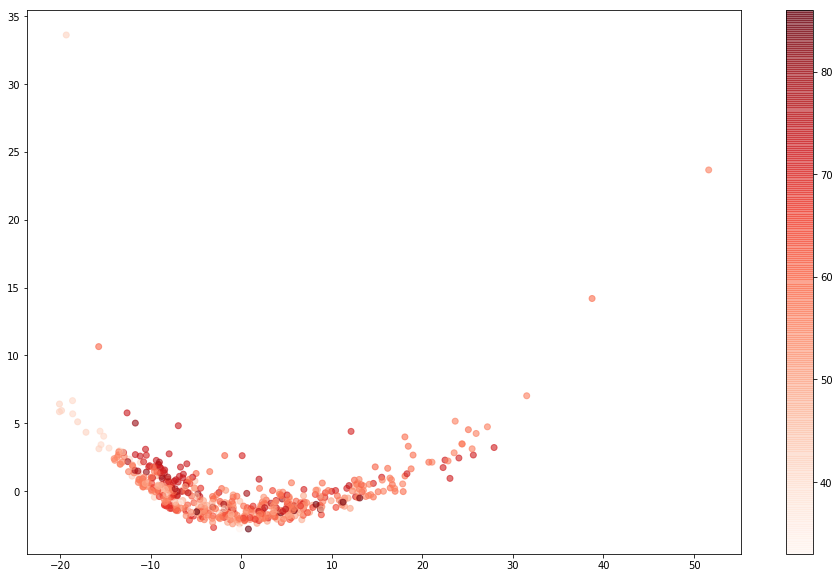

In [56]:
plt.figure(figsize=(16,10))
plt.scatter(df['one'], df['two'],c=df['age'], cmap='Reds', alpha=.6)
plt.colorbar()
'''
sns.scatterplot(
    x="one", y="two",
    hue='label',
    data=df,
    legend="full",
    alpha=0.3
)
'''

## t-SNE Visualization

In [105]:
#
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=300)
tsne_results = tsne.fit_transform(points)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 528 samples in 0.001s...
[t-SNE] Computed neighbors for 528 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 528 / 528
[t-SNE] Mean sigma: 3.182301
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.065475
[t-SNE] KL divergence after 300 iterations: 0.305689


In [106]:
df['tsne-one'] = tsne_results[:,0]
df['tsne-two'] = tsne_results[:,1]

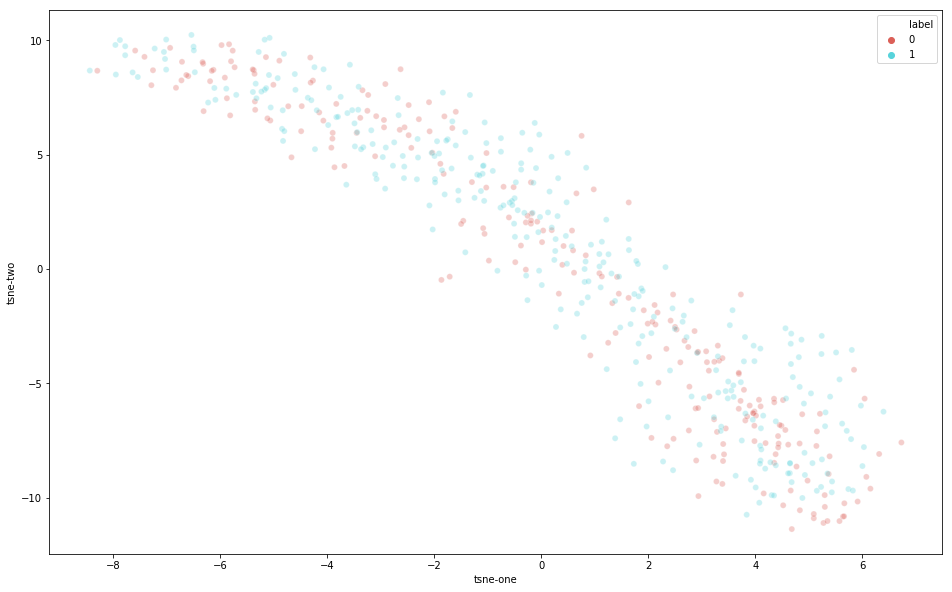

In [107]:
plt.figure(figsize=(16,10))


sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="label",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=0.3
)



#plt.scatter(df['tsne-one'], df['tsne-two'],c=df['label'], cmap='Reds', alpha=.6)
#plt.colorbar()


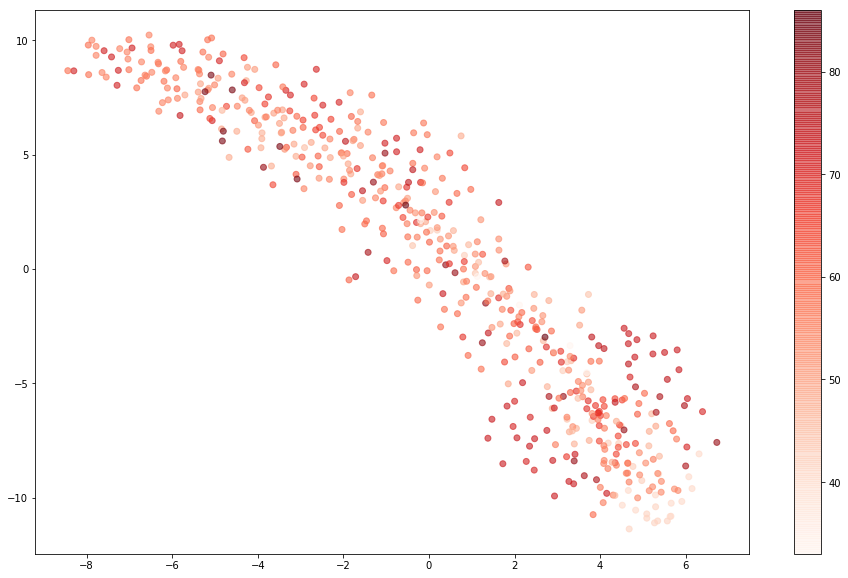

In [108]:
plt.figure(figsize=(16,10))

plt.scatter(df['tsne-one'], df['tsne-two'],c=df['age'], cmap='Reds', alpha=.6)
plt.colorbar()
